# Semantic Segmentation for Autonomous Driving


---



General Instructions

Software Pre-reqs: Google Chrome Browser

1. Click on the download link to get the notebook file - we provide the drive link
2. Go to https://colab.research.google.com.
3. Click on File --> Upload Notebook --> Upload Tab --> Choose file (Choose the downloaded notebook file [provide filename.ipynb])



add headings before major sections
mention conclusion after that
category viz required in our case ?
Show the normalization technique in case of images - mention other normalization techniques
plot convergence graphs


# Import Necessary Python Packages

In [1]:
# WARNING: DO NOT modify any portion of this note!

import tensorflow as tf
from tensorflow import keras
import keras.models as models
from keras.layers import Conv2D, Reshape, merge, BatchNormalization
from keras.layers import MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.layers import Dense, Activation, Flatten, Permute, Layer, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import plot_model

import cv2
import numpy as np
import json
import random
import os

# import plotting libraries
import matplotlib.pyplot as plt

# global params
image_height = 360
image_width = 480
data_shape = image_height * image_width

# cite literature on this
class_weighting= [0.2595, 0.1826, 4.5640, 0.1417, 0.5051, 0.3826, 9.6446, 1.8418, 6.6823, 6.2478, 3.0, 7.3614]

# modules required to install
!apt-get -qq install -y graphviz && pip install -q pydot

# import custom utility package
from utils import *


Using TensorFlow backend.


# CamVid Dataset

## Download the CamVid Dataset

In [2]:
# Download the dataset (CamVid) -- put personal github repo link
!git clone https://github.com/alexgkendall/SegNet-Tutorial.git

Cloning into 'SegNet-Tutorial'...
remote: Enumerating objects: 2785, done.
remote: Total 2785 (delta 0), reused 0 (delta 0), pack-reused 2785
Receiving objects: 100% (2785/2785), 340.84 MiB | 35.62 MiB/s, done.
Resolving deltas: 100% (81/81), done.


## Explore the CamVid dataset

We use the CamVid dataset for all our training, testing and validation. The dataset was captured with a camera mounted on a automobile to generate heteregenous scenes that interests autonomous driving.

- root directory of training images: `<Home>/train/`
- root directory of testing images: `<Home>/test/`
- root directory of validation images: `<Home>/val/`

Each of the above directories contain the image data stored as a `.png` file.

- root directory of annotations of train data: `<HOME>/trainannot/`

The trainannot directory contains the annotations (class labels) per-pixel stored as a `.png` file.

The `test.txt`, `train.txt` and `val.txt` stores the filepath of the images and its annotation data.

The annotations for other images are also arranged similar to that of training images. Please run the following note, to understand the directory structure of the CamVid dataset.

In [3]:
startpath = "./SegNet-Tutorial/CamVid"
for root, dirs, files in os.walk(startpath):
  '''
    print the directory structure rooted at <startpath>
  '''
  level = root.replace(startpath, '').count(os.sep)
  indent = ' ' * 4 * (level)
  print('{}{}/'.format(indent, os.path.basename(root)))
  subindent = ' ' * 4 * (level + 1)
  depth = 0
  for f in files:
    if depth > 4:
      print ("{}..".format(subindent))
      break
    depth += 1
    print('{}{}'.format(subindent, f))

CamVid/
    test.txt
    train.txt
    val.txt
    test/
        Seq05VD_f01770.png
        Seq05VD_f04080.png
        0001TP_008790.png
        Seq05VD_f02130.png
        Seq05VD_f00060.png
        ..
    train/
        0001TP_007380.png
        0016E5_02160.png
        0006R0_f01110.png
        0016E5_01680.png
        0016E5_01800.png
        ..
    valannot/
        0016E5_08001.png
        0016E5_08109.png
        0016E5_07961.png
        0016E5_07979.png
        0016E5_08027.png
        ..
    trainannot/
        0001TP_007380.png
        0016E5_02160.png
        0006R0_f01110.png
        0016E5_01680.png
        0016E5_01800.png
        ..
    val/
        0016E5_08001.png
        0016E5_08109.png
        0016E5_07961.png
        0016E5_07979.png
        0016E5_08027.png
        ..
    testannot/
        Seq05VD_f01770.png
        Seq05VD_f04080.png
        0001TP_008790.png
        Seq05VD_f02130.png
        Seq05VD_f00060.png
        ..


**Next, we understand the scale of the data and the distribution with respect to training and testing data.**

In [4]:
!echo \# of training images: `cat SegNet-Tutorial/CamVid/train.txt | wc -l`
!echo \# of testing images: `cat SegNet-Tutorial/CamVid/test.txt | wc -l`
!echo \# of validation images: `cat SegNet-Tutorial/CamVid/val.txt | wc -l`

# of training images: 367
# of testing images: 233
# of validation images: 101


**Visualize the dataset annotation**

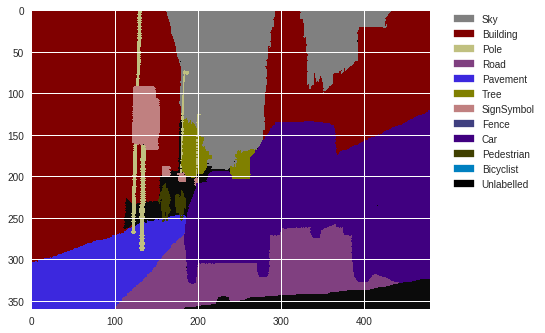

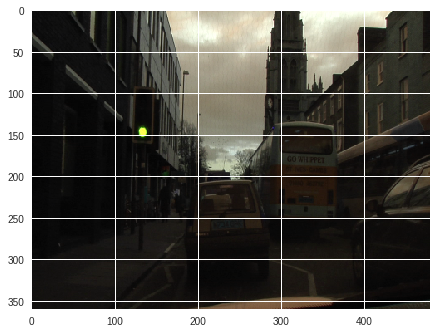

In [5]:
# Run with different modes and indices to explore the dataset
image_index = 0
mode = "train"

image = get_image(mode, image_index)
label = get_label(mode, image_index)
plt.imshow(image)
Visualizer().visualize_ground_truth(image, label)

# Understanding Semantic Segmentation

![alt text](https://www.jeremyjordan.me/content/images/2018/05/Screen-Shot-2018-05-17-at-9.02.15-PM.png)

**3D array representation of the one-hot encoded class label map.**

Categorical class labels are encoded as a *one-hot* bit vector which essentially creates an output channel for each of the class labels.



![alt text](https://www.jeremyjordan.me/content/images/2018/05/Screen-Shot-2018-05-16-at-9.36.00-PM.png)

In [0]:
# WARNING: DO NOT modify any portion of this code!
def one_hot_it(labels):
  '''
   <input>: 2D np array which stores the label index per pixel
   <output>: one-hot encoded 3D np array
   
  '''
  img = np.zeros([image_height, image_width, 12])

  for i in range(image_height):
      for j in range(image_width):
          img[i, j, labels[i][j]] = 1

  # return the one-hot encoded img
  return img

# Load Data -- Convert to Numpy Array

The problem representation becomes even more complicated in comparison to the object detection

## Data Normalization


*Neural* networks work best when we do data normalization. In the context of images, we perform a histogram equalization to bring out better contrast [2] and cut down the effects of uneven lighting conditions. The method  `
normalized` in the note below shows the python implementation of the theory being discussed here.



![Effect of histogram equalization](https://docs.opencv.org/3.1.0/histogram_equalization.png)
<br> Figure: Effect of histogram equalization [1]
<br><br>

![Effect of histogram equalization on images](https://docs.opencv.org/3.1.0/equalization_opencv.jpg)
<br> Figure: Effect of histogram equalization on images

[1] https://en.wikipedia.org/wiki/Histogram_equalization

[2] https://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html


In [0]:
# WARNING: DO NOT modify any portion of this note!
def normalized(rgb):
  
  '''
    <input>: opencv image object
    <output>: normalized opencv image object
    
    This method runs a histogram equalization of the
    input image to nullify the effect of uneven
    lighting conditions.
    
  '''
  # initialize with a zero matrix
  norm=np.zeros((rgb.shape[0], rgb.shape[1], 3),np.float32)

  # convert RGB to opencv BGR format
  b = rgb[:,:,0]
  g = rgb[:,:,1]
  r = rgb[:,:,2]

  # run a histogram equalization on the image
  # filter out the effects due to uneven lighting conditions
  norm[:,:,0]=cv2.equalizeHist(b)
  norm[:,:,1]=cv2.equalizeHist(g)
  norm[:,:,2]=cv2.equalizeHist(r)

  # return the normalized image
  return norm

## Importing Image Data as a Numpy Array

In [0]:
DataPath = './SegNet-Tutorial/CamVid/'
def load_multiple_data(mode, sample_size=-1):
  '''
    load a subsample of the original dataset
    mode: train / test / val <type>: str
    dataset_size (optional): sample size
   
  '''
  # containers for the data and the labels
  img_cont = []
  label_cont = []
  
  # read the contents of the txt file
  with open(DataPath + mode +'.txt') as f:
    filepaths = f.readlines()
    filepaths = [line.split(' ') for line in filepaths]
  
  whole_dataset_size = len(filepaths)
  
  if sample_size > whole_dataset_size:
    raise Exception("Sample size can not be greater than population size!")
  
  if sample_size > 0:
    indices = random.sample(range(0, whole_dataset_size), sample_size)
  else:
    indices = range(0, whole_dataset_size)
    
  
  for each_index in indices:
    img, label = load_single_data(mode, each_index)
    img_cont.append(img[0])
    label_cont.append(label[0])
    
  return (np.array(img_cont), np.array(label_cont))
  
  
def load_single_data(mode, index=None):
  '''
    <input>:
      mode: train / test / val | <type>: str
      index: <int>
      
    <output>:
      a tuple containing:
        img data as numpy array
        label data as numpy array
  '''

  # read the contents of the txt file
  with open(DataPath + mode +'.txt') as f:
    filepaths = f.readlines()
    filepaths = [line.split(' ') for line in filepaths]
  
  whole_dataset_size = len(filepaths)
  if index > whole_dataset_size:
    raise Exception("Index out of bound!")
  
  label_path = DataPath + filepaths[index][1][15: ].strip()
  img_path = DataPath + filepaths[index][0][15: ]

  # Input image normalized and converted to a 3D numpy array 
  img = np.rollaxis(normalized(cv2.imread(img_path)),2)
  img = np.array([img])
  # Label map converted to a one hot encoded 3D numpy array
  label = one_hot_it(cv2.imread(label_path))
  label = np.array([label])
  
  return img, label

# Build the Semantic Segmentation Architecture

## Encoding layers


In [0]:
# set seed for the randomizer
np.random.seed(7)

def create_encoding_layers():
  
  # params for the Encoder layers
  kernel = 3
  filter_size = 64
  pad = # TODO Fill up a number.
  pool_size = 2
  
  return [ 
      
    # BLOCK 1
    
    # HINT: What is the dimension of the input layer?
    # Can you figure out what happens to the shape of output when you run a Convolutional filter directly on
    # the input image? 
    
    # TODO layer 1
    
    # TODO layer 2

    # HINT: If normalization helps the input, how about the hidden layers?
    # TODO layer 3

    # HINT: what happens to irregular weights? Which layer can solve it?
    # TODO layer 4
    
    # HINT: HEY! Don't you think the memory is bloating up? Should we do something about it?
    # TODO layer 5
    
    # BLOCK 2
    # TODO
      
    # BLOCK 3
    # TODO
      
    # BLOCK 4
      
    # TODO
    # change activations: sigmoid, relu, tanh
    # kernel size change
    # max pooling, average pooling
  ]

## Decoding layers

In [0]:
def create_decoding_layers():
  
  # params for decoding layers
  kernel = 3
  filter_size = 64
  pad = 1
  pool_size = 2
  
  return[
      
    # BLOCK 1
    # HINT: Check the shape of the last encoding layer created.

    # BLOCK 2
    # Max pooling would have subsampled the feature maps. How do you revert?

    # BLOCK 3
    # can you repeat for this block?
      
    # BLOCK 4
    # Let's see what we have learnt!
      
  ]

## Classification layer

In [0]:
def create_classification_layer():
  num_classes = 12

  return [
    # add a Conv2D layer with 1 filter for each class label

    # Flatten the image to apply softmax on the final output

    # general rearragement of the data for softmax to work

    # softmax layer: predicted one-hot encoding per pixel
  ]

## Putting it all together

In [12]:
# add the created layers to the keras sequential model

save_model = True
mini_segnet = models.Sequential()

# input layer: an image with RGB channels
mini_segnet.add(Layer(input_shape=(3, image_height, image_width)))
print_last_layer_info(mini_segnet)

for layer in create_encoding_layers():
    mini_segnet.add(layer)
    print_last_layer_info(mini_segnet)

for layer in create_decoding_layers():
    mini_segnet.add(layer)
    print_last_layer_info(mini_segnet)

for layer in create_classification_layer():
    mini_segnet.add(layer)
    print_last_layer_info(mini_segnet)
    
    
if save_model:
  # Save model to JSON dict -- for later use
  with open('mini_segnet_model.json', 'w') as outfile:
      outfile.write(json.dumps(json.loads(mini_segnet.to_json()), indent=2))
# Encoder - Decoder architecture ready
# Add classification layer to predict the class labels for pixel values

last layer information
name: layer_1
input shape:(None, 3, 360, 480)
output shape:(None, 3, 360, 480)
last layer information
name: zero_padding2d_1
input shape:(None, 3, 360, 480)
output shape:(None, 3, 362, 482)
last layer information
name: conv2d_1
input shape:(None, 3, 362, 482)
output shape:(None, 64, 360, 480)
last layer information
name: batch_normalization_1
input shape:(None, 64, 360, 480)
output shape:(None, 64, 360, 480)
last layer information
name: activation_1
input shape:(None, 64, 360, 480)
output shape:(None, 64, 360, 480)
last layer information
name: max_pooling2d_1
input shape:(None, 64, 360, 480)
output shape:(None, 64, 180, 240)
last layer information
name: zero_padding2d_2
input shape:(None, 64, 180, 240)
output shape:(None, 64, 182, 242)
last layer information
name: conv2d_2
input shape:(None, 64, 182, 242)
output shape:(None, 128, 180, 240)
last layer information
name: batch_normalization_2
input shape:(None, 128, 180, 240)
output shape:(None, 128, 180, 240)
last 

## Summary

In [33]:
mini_segnet.summary()
plot_model(mini_segnet, show_shapes=True, show_layer_names=True, rankdir='TB', to_file='model.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Layer)              (None, 3, 360, 480)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 3, 362, 482)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 360, 480)      1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 360, 480)      1920      
_________________________________________________________________
activation_1 (Activation)    (None, 64, 360, 480)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 180, 240)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 64, 182, 242)      0         
__________

# Training the model

**Cross Entropy loss function**

---



Cross Entropy is typically used to measure the similarity between two probability distributions. In the context of machine learning, the cross entropy measures how close is the predicted bit vector of class labels to the ground truth bit vector.

For example:

If the true distribution (one-hot encoding)for a particular data point is [0, 1, 0] and the predicted vector is [0.228, 0.619, 0.153]. The quatification of the *closeness* parameter is revealed by the cross-entropy formula [Figure].

Therefore, intuitively, minimizing the cross-entropy loss should improve our machine learning model.

![alt text](https://i.stack.imgur.com/NWK2v.png =200x40)
<br> Figure: Cross-Entropy formula [1]

[1] https://i.stack.imgur.com/NWK2v.png

In [0]:
# load the model file
with open('mini_segnet_model.json') as model_file:
    mini_segnet = models.model_from_json(model_file.read())

In [0]:
mini_segnet.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["categorical_accuracy"])

In [0]:
# put checkpoint to save the weights
filepath = "weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
earlystopcheck = EarlyStopping(monitor="loss", min_delta=0.00001, patience=3)

callbacks_list = [checkpoint, earlystopcheck]


In [17]:
nb_epoch = 20
batch_size = 6 # 6
num_iters = 10 # 10
training_loss = []
val_loss = []
training_acc = []
val_acc = []

for iter in range(0, num_iters):
  
  train_subset_size = 15 # 12
  val_subset_size = 5 # 5
  
  # sample training data
  train_data, train_label = load_multiple_data("train", train_subset_size)
  train_label = np.reshape(train_label, (train_subset_size, data_shape, 12))
  
  # sample validation data
  val_data, val_label = load_multiple_data("val", val_subset_size)
  val_label = np.reshape(val_label, (val_subset_size, data_shape, 12))
  
  print ("Iteration # {0}".format(iter))
  print ("Generating sample size {0} from train_data".format(train_subset_size))

  history = mini_segnet.fit(train_data, train_label, batch_size=batch_size, epochs=nb_epoch,
                    verbose=1, class_weight=class_weighting, callbacks=callbacks_list, validation_data=(val_data, val_label), shuffle=True)

  training_loss += history.history['loss']
  val_loss += history.history['val_loss']
  training_acc += history.history['categorical_accuracy']
  val_acc += history.history['val_categorical_accuracy']
  

Iteration # 0
Generating sample size 15 from train_data
Train on 15 samples, validate on 5 samples
Epoch 1/20
15/15 [==============================] - 22s 1s/step - loss: 3.4497 - categorical_accuracy: 0.2490 - val_loss: 10.4904 - val_categorical_accuracy: 0.2754

Epoch 00001: loss improved from inf to 3.44967, saving model to weights.best.hdf5
Epoch 2/20
15/15 [==============================] - 4s 237ms/step - loss: 2.8387 - categorical_accuracy: 0.2488 - val_loss: 10.2926 - val_categorical_accuracy: 0.2701

Epoch 00002: loss improved from 3.44967 to 2.83867, saving model to weights.best.hdf5
Epoch 3/20
15/15 [==============================] - 4s 238ms/step - loss: 1.9982 - categorical_accuracy: 0.3086 - val_loss: 8.4268 - val_categorical_accuracy: 0.2795

Epoch 00003: loss improved from 2.83867 to 1.99820, saving model to weights.best.hdf5
Epoch 4/20
15/15 [==============================] - 4s 236ms/step - loss: 2.0656 - categorical_accuracy: 0.1913 - val_loss: 7.2344 - val_categoric

## Plot training loss and validation loss

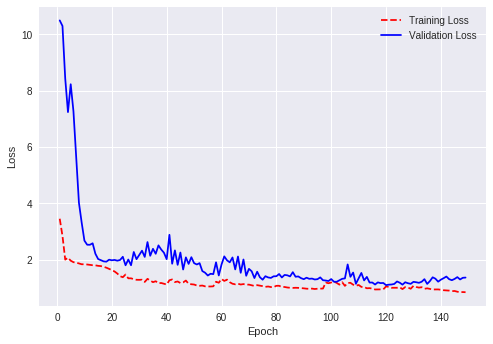

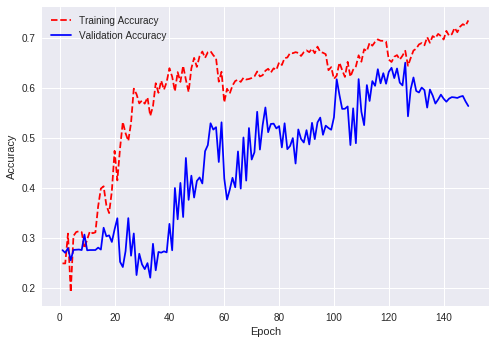

In [18]:
plot_history(training_loss, val_loss, training_acc, val_acc)

# Testing the model


In [0]:
# load the model:
with open('mini_segnet_model.json') as model_file:
    mini_segnet = models.model_from_json(model_file.read())

# load weights
mini_segnet.load_weights("weights.best.hdf5")

# Compile model (required to make predictions)
mini_segnet.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

## Evaluate the model on the test data

In [28]:
# load the test data
max_iters = 10
acc_per_batch = []

for iter in range(0, max_iters):
  sample_size = 15
  test_data, test_label = load_multiple_data("test", sample_size)
  test_label = np.reshape(test_label,(sample_size, data_shape, 12))
  print ("Iteration #: " + str(iter))

  scores = mini_segnet.evaluate(test_data, test_label, verbose=1)
  acc_per_batch.append(scores[1] * 100.0)

print ("mean %s: %.2f%%" % (mini_segnet.metrics_names[1], np.mean(acc_per_batch)))

mean acc: 53.25%


## Visualizing model output on test samples

(360, 480)


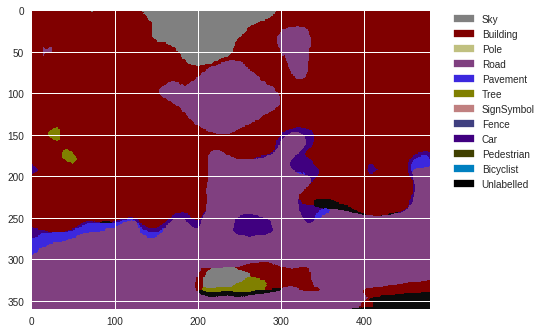

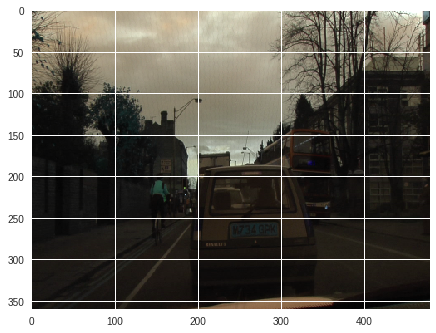

In [31]:
mode = "test"
# image = get_random_image(mode)
image = get_image(mode, 14)
plt.imshow(image)
Visualizer().visualize(image, mini_segnet)